### Importing Libraries

In [1]:
%matplotlib inline
import numpy as np
from numpy import empty
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
import metpy as metpy
import netCDF4
from netCDF4 import Dataset
from ctsm_py import utils  #when using utils in the CTSM_py directory (work); also need to do pip install -e
#import esmlab  #note: need to make sure to install in current environment first
#note that CMIP6 doesn't have metpy; use conda env:miniconda-analysis

### Defining simulation information

In [2]:
datadir        = "/glade/p/cgd/tss/people/dll/TRENDY2019_History/"
sim            = "S0_control/"
datadir        = datadir + sim
simname        = "TRENDY2019_S0_control_v2.clm2.h1."
var            = "GPP"
years          = "170001-201812"

maxval = "True"

In [3]:
print(datadir+simname+var+"."+years+".nc")

/glade/p/cgd/tss/people/dll/TRENDY2019_History/S0_control/TRENDY2019_S0_control_v2.clm2.h1.GPP.170001-201812.nc


In [3]:
#This is an example copied from Dan's script -- helps to read in multiple variables
#dir = 
#sim = 
#pref = 'lnd/proc/tseries/month_1' 
#suff = ".clm2.h0."
#variables = [" "]
#pattern   = dir + sim + proc + pref + '{var}' + suff
#files = [pattern.format(var=var) for var in variables]

#for multiple files, use xr.open_mfdataset; dan also uses utils.time_set_mid to make the time dims work properly

#365*utils.weighted_annual_mean --> weights by days/month
#timeslice: ix_time = (ds['time.year']>1963) & (ds['time.year']<2014) # note that dan's dataset is 'ds'
#plt.subplot(121) #-->1 row, 2 plots, plot 1
#signal.detrend (?)

In [4]:
data1          = utils.time_set_mid(xr.open_dataset(datadir+simname+var+"."+years+".nc", decode_times=True), 'time')

#Use below for testing
#data1          = xr.open_dataset("/glade/scratch/dll/archive/TRENDY2019_S0_constant_v2/lnd/hist/TRENDY2019_S0_constant_v2.clm2.h1.2018-12.nc")

In [ ]:
print(data1)

### Reading in Land Use Change dataset for masking the real distribution of each crop type

In [5]:
#Note: Update this based on the LUC file from your simulation
lucdat    = xr.open_dataset("/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/release-clm5.0.24/landuse.timeseries_0.9x1.25_hist_78pfts_TRENDY_simyr1700-2018_c190814.nc")

In [ ]:
print(lucdat)

### Reading in variables from data file

In [6]:
years        = np.arange(1700,2019,1)
month          = np.arange(0,12,1)
area           = data1.area
landfrac       = data1.landfrac
lat            = data1.lat
lon            = data1.lon
time           = data1.time

ixy            = data1.pfts1d_ixy
jxy            = data1.pfts1d_jxy
#coltype        = data1.pfts1d_itype_col
vegtype        = data1.pfts1d_itype_veg
cellwtd        = data1.pfts1d_wtgcell

gpp            = data1.GPP
#print(type(gpp))
#print(gpp.dims)
#print (gpp['time'].values)
#print(gpp)

### Reading in variables from LUC file

In [7]:
pctcft         = lucdat.PCT_CFT
pctcrop        = lucdat.PCT_CROP
#print(pctcft)
#print(pctcrop)

### Defining proportion of each crop type (pctcft) within the grid crop area (pctcrop)

In [8]:
%%time
# This takes ~4 minutes (pctcft = 319 x 64 x 192 x 288)
cropwts        = (pctcft/100) * (pctcrop/100)
print(cropwts)

<xarray.DataArray (time: 319, cft: 64, lsmlat: 192, lsmlon: 288)>
array([[[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]],


       ...,


       [[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]]])
Coordinates:
  * cft      (cft) int32 15 16 17 18 19 20 21 22 23 ... 71 72 73 74 75 76 77 78
  * time     (time) int32 1700 1701 1702 1703 1704 ... 2014 2015 2016 2017 2018
Dimensions without coordinates: lsmlat, lsmlon
CPU times: user 8.77 s, sys: 1min 16s, total: 1min 25s
Wall time: 4min 4s


### Creating crop mask based on weights of specific crop types
Masking regions with crop area <0.5%

In [9]:
%%time
# this takes ~2 minutes

#values replaced with nan by default
cropwtsmask    = cropwts.where(cropwts>0.005)
print(cropwtsmask)


<xarray.DataArray (time: 319, cft: 64, lsmlat: 192, lsmlon: 288)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]],


       ...,


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]])
Coordinates:
  * cft      (cft) int32 15 16 17 18 19 20 21 22 23 ... 71 72 73 74 75 76 77 78
  * time     (time) int32 1700 1701 1702 1703 1704 ... 2014 2015 2016 2017 2018
Dimensions without coordinates: lsmlat, lsmlon
CPU times: user 4.18 s, sys: 34.2 s, total: 38.4 s
Wall time: 1min 35s


In [ ]:
#crop2    = cropwtsmask.isel(time=300)
#cropsum  = crop2.sum
#can't figure out how to make sure the sum of the weights is 1
#print(cropsum)

### Quick plot to determine if mask works correctly

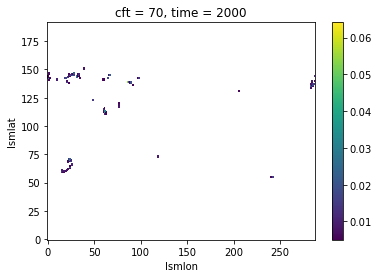

In [10]:
cropwtsmask.isel(time=300,cft=55).plot()
#cropwtsmask.isel(time=300,cft=24).plot(robust=True) #-->this statistically selects min & max values

### Processing time and area variables

In [11]:
#not sure area vars are needed here
area.metpy.convert_units('m^2')
landarea       = area*landfrac
landarea.attrs['units']   = 'm^2'

num_years       = len(time)//12
print(num_years)
npftvector      = len(ixy)
#type(cellwtd)

319


In [12]:
#print (cellwtd.values)
cellwt = cellwtd.values
cellwt_float =cellwt.astype(float)

#print (type(cellwt_float[1]))

nlat = len(lat.values)
nlon = len(lon.values)
nvegtype = len(vegtype.values)
ntim   = len(time.values)
npft = (np.max(vegtype))
npft = npft.astype(int)
pftlist = np.arange(0,(npft.values+1),1)

### Defining PFT names

In [13]:
pftname =   ["needleleaf_evergreen_temperate_tree",
             "needleleaf_evergreen_boreal_tree",
             "needleleaf_deciduous_boreal_tree",
             "broadleaf_evergreen_tropical_tree",
             "broadleaf_evergreen_temperate_tree",
             "broadleaf_deciduous_tropical_tree",
             "broadleaf_deciduous_temperate_tree",
             "broadleaf_deciduous_boreal_tree",
             "broadleaf_evergreen_shrub",
             "broadleaf_deciduous_temperate_shrub",
             "broadleaf_deciduous_boreal_shrub",
             "c3_arctic_grass",
             "c3_non-arctic_grass",
             "c4_grass",
             "unmanaged_c3_crop",
             "unmanaged_c3_irrigated",
             "temperate_corn",
             "irrigated_temperate_corn",
             "spring_wheat",
             "irrigated_spring_wheat",
             "winter_wheat",
             "irrigated_winter_wheat",
             "soybean",
             "irrigated_soybean",
             "barley",
             "irrigated_barley",
             "winter_barley",
             "irrigated_winter_barley",
             "rye",
             "irrigated_rye",
             "winter_rye",
             "irrigated_winter_rye",
             "cassava",
             "irrigated_cassava",
             "citrus",
             "irrigated_citrus",
             "cocoa",
             "irrigated_cocoa",
             "coffee",
             "irrigated_coffee",
             "cotton",
             "irrigated_cotton",
             "datepalm",
             "irrigated_datepalm",
             "foddergrass",
             "irrigated_foddergrass",
             "grapes",
             "irrigated_grapes",
             "groundnuts",
             "irrigated_groundnuts",
             "millet",
             "irrigated_millet",
             "oilpalm",
             "irrigated_oilpalm",
             "potatoes",
             "irrigated_potatoes",
             "pulses",
             "irrigated_pulses",
             "rapeseed",
             "irrigated_rapeseed",
             "rice",
             "irrigated_rice",
             "sorghum",
             "irrigated_sorghum",
             "sugarbeet",
             "irrigated_sugarbeet",
             "sugarcane",
             "irrigated_sugarcane",
             "sunflower",
             "irrigated_sunflower",
             "miscanthus",
             "irrigated_miscanthus",
             "switchgrass",
             "irrigated_switchgrass",
             "tropical_corn",
             "irrigated_tropical_corn",
             "tropical_soybean",
             "irrigated_tropical_soybean"]
print(len(pftname))

78


In [14]:
print (vegtype.values[1])

0.0


### Creating gridded array

In [15]:
gridded = empty([ntim,npft.values+1,nlat,nlon])

%%time
# Takes ~4 minutes
gridded[:, vegtype.values.astype(int), jxy.values.astype(int) - 1, ixy.values.astype(int) - 1] = gpp.values


CPU times: user 51.9 s, sys: 59.9 s, total: 1min 51s
Wall time: 2min 50s


In [ ]:
print(gridded)

### Adding dimensions and coordinates

In [16]:
#print(gridded.shape)
grid_dims = xr.DataArray(gridded, dims=("time","pft","lat","lon"))
grid_dims = grid_dims.assign_coords(time=data1.time,pft=pftname,lat=lat.values,lon=lon.values)
grid_dims.name = var
print(grid_dims)

<xarray.DataArray 'GPP' (time: 3828, pft: 78, lat: 192, lon: 288)>
array([[[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]],


       ...,


       [[[0., ..., 0.],
         ...,
         [0., ..., 0.]],

        ...,

        [[0., ..., 0.],
         ...,
         [0., ..., 0.]]]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * pft      (pft) <U35 'needleleaf_evergreen_temperate_tree' ... 'irrigated_tropical_soybean'
  * time     (time) object 1700-01-16 11:45:00 ... 2018-12-16 12:00:00


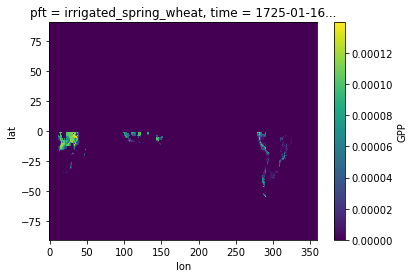

In [17]:
#verify that this works
grid_dims.isel(time=300,pft=19).plot()

### Reshaping the time dimension to year, month

In [18]:
reshaped  = grid_dims.values.reshape(num_years,12,*grid_dims.values.shape[1:])
grid_reshape   = xr.DataArray(reshaped, dims=("years","month","pft","lat","lon"))
grid_reshape   = grid_reshape.assign_coords(years=years,month=month,pft=pftname,lat=lat.values,lon=lon.values)

In [ ]:
print(grid_reshape)

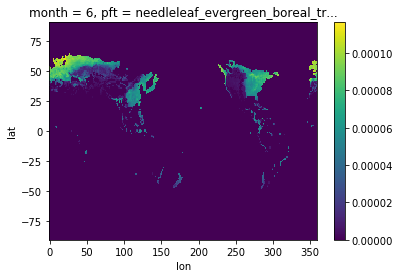

In [19]:
#verify that this works
grid_reshape.isel(years=300,month=6,pft=1).plot()

<xarray.DataArray (years: 319, pft: 64, lat: 192, lon: 288)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]],


       ...,


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]])
Coordinates:
  * pft      (pft) int32 15 16 17 18 19 20 21 22 23 ... 71 72 73 74 75 76 77 78
  * years    (years) int32 1700 1701 1702 1703 1704 ... 2014 2015 2016 2017 2018
Dimensions without coordinates: lat, lon


### Redefining the dimension names for the crop weights mask

In [21]:
cropwtsmask    = cropwtsmask.rename({'time':'years','cft':'pft','lsmlat':'lat','lsmlon':'lon'})

In [22]:
#print(years)
#print(month)
#print(grid_reshape)

<xarray.DataArray (years: 319, month: 12, pft: 78, lat: 192, lon: 288)>
array([[[[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]],


        ...,


        [[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]]],



       ...,



       [[[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]],


        ...,


        [[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]]]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * pft      (pft) <U35 'needleleaf_evergreen_temperate_tre

### Applying area mask to crop PFTs 

In [23]:
sub_gpp = grid_reshape.isel(pft=slice(14,78))
cropwtsmask['pft']    = sub_gpp.pft

gridded_wts    = sub_gpp * cropwtsmask

In [ ]:
print(gridded_wts)
print(gridded_wts.pft)

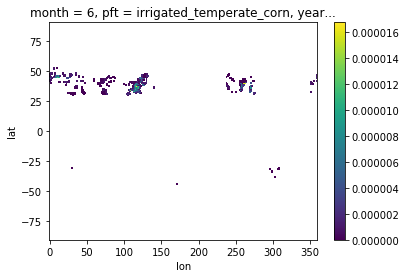

In [24]:
#verify that this works
gridded_wts.isel(years=300,month=6,pft=3).plot()

### Subsetting the natural PFTs to prepare for concatenation

In [25]:
natpft       = grid_reshape.isel(pft=slice(0,14))
print(grid_reshape.isel(pft=slice(0,14)))
print(natpft.pft)

<xarray.DataArray (years: 319, month: 12, pft: 14, lat: 192, lon: 288)>
array([[[[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]],


        ...,


        [[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]]],



       ...,



       [[[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]],


        ...,


        [[[0., ..., 0.],
          ...,
          [0., ..., 0.]],

         ...,

         [[0., ..., 0.],
          ...,
          [0., ..., 0.]]]]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * pft      (pft) <U35 'needleleaf_evergreen_temperate_tre

In [26]:
%%time
# Takes a really long time!

wtd_grid_data       = xr.concat([grid_reshape.isel(pft=slice(0,14)), gridded_wts], dim='pft')

print(wtd_grid_data)
print(wtd_grid_data.pft)

<xarray.DataArray (years: 319, month: 12, pft: 78, lat: 192, lon: 288)>
array([[[[[ 0., ...,  0.],
          ...,
          [ 0., ...,  0.]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]],


        ...,


        [[[ 0., ...,  0.],
          ...,
          [ 0., ...,  0.]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]]],



       ...,



       [[[[ 0., ...,  0.],
          ...,
          [ 0., ...,  0.]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]],


        ...,


        [[[ 0., ...,  0.],
          ...,
          [ 0., ...,  0.]],

         ...,

         [[nan, ..., nan],
          ...,
          [nan, ..., nan]]]]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.057594 -88.11518 ... 89.057594 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.25 357.5 358.75
  * month    (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * years    (years) int64 

In [27]:
#How to add variable name? 

wtd_grid_data.to_netcdf(path="/glade/scratch/dll/GPPgriddedTest.nc")

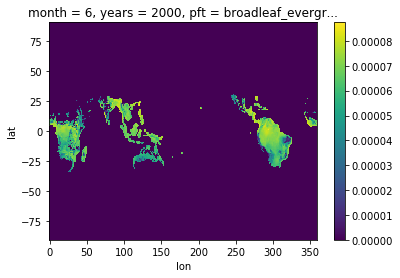

In [50]:
#looking at file
wtd_grid_data.isel(years=300,month=6,pft=4).plot()

Should I also apply the "where" statement to the natural veg? 

### Below code is more data processing

In [28]:
%%time
#takes ~5 minutes

#perhaps want to do this after file is written. 

#another option from Will (maybe example in monthlySVD example): write out grid_reshape.max.groupby(time.year)

#note: maxval set above
if (maxval == "True"):
#    if var = "GRAINC_TO_FOOD"
#       gridded_yr = gridded.sum() 
#CHANGE VAR TO wtd_grid_data
   gridded_yr  = grid_reshape.max(dim='month')
else:
   gridded_yr  = grid_reshape.mean(dim='month')

CPU times: user 18 s, sys: 35.1 s, total: 53.1 s
Wall time: 2min 56s


In [ ]:
print(gridded_yr)

### Weighting by actual crop area
## This code doesn't yet work!

### writing netCDF file

In [ ]:
gridded_yrs.to_netcdf(path="/glade/scratch/dll/griddedExample.nc")
#grid_dims.to_netcdf(path="/glade/scratch/dll/griddedExample.nc")

To do:
- correct time dimension to start in Jan
    --> note that I still can't get the utils working. It doesn't seem to recognize the ctsm_py module. 
- mask data by PFT distribution in the land surface dataset

## Old/Not working Code

In [ ]:
#doesn't work yet... need to investigate
reshaped = grid_dims.values.reshape(num_years, 12, *gridded.values.shape[1:])
 
values = xr.DataArray(reshaped,
                      dims=('year','month','lat','lon'),
                      coords=(np.arange(1850, 1850+num_years), np.arange(12), data.lat, data.lon))
values.attrs['units'] = data.attrs['units']
sims[sim_name] = values

In [ ]:
# For TRENDY use, not for CTSM_py commit
#note: HTOP ('theightpft') also requested, but info not in old script
vars_in = ['TLAI', 'FCTR', 'GPP', 'NPP', 'TOTVEGC', 'TV']
vars_out = ['lai','transpft','gpppft','npppft','cVegpft','tskinpft']
units_out_list = ['None','W m-2','kg C m-2 s-1','kg C m-2 s-1','K']
long_name_out_list = ['Leaf Area Index','Vegtype level transpiration','Vegtype level GPP','Vegtype level NPP','Vegtype level Carbon in Vegetation','Vegtype level Skin temperature']
unit_convert_list = [1,1,1.e-3,1.e-3,1.e-3,1]

In [ ]:
#%%time
#this is time intensive: ~6.5s to regrid 1 month; 2.5min for timeseries
#gridded_test = gridded
#new code added above that removes loop
#for i in range(npftvector):
#    #gridded = empty([ntim,77,nlat,nlon])
#    #print ('i = ',i)
#    if (cellwt_float[i]>0):
#        col     = ixy.values[i].astype(int) - 1
#        row     = jxy.values[i].astype(int) - 1 
#        vegidx = vegtype.values[i].astype(int)
#        #print (gridded[:,vegidx, row, col])
#        #print (gpp.values[:,i])
#        gridded_test[:,vegidx, row, col] = gpp.values[:,i]
#        #print (i)